# Import some stuff

In [1]:
%matplotlib inline
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from architecture.parameters.lstmParameters import LstmParameters
from architecture.realImagLSTMArchitecture import RealImagLSTMArchitecture

import os
import matplotlib.pyplot as plt
from system.realImagLSTMPreAndPostProcessor import RealImagLSTMPreAndPostProcessor
from system.realImagLSTMSystem import RealImagLSTMSystem
import tensorflow as tf
import numpy as np

# Initialize the network

In [2]:
sessionsName = "test_RealImag_newNew_"

batch_size = 64
params = LstmParameters(lstmSize=512, batchSize=batch_size, signalLength=5120, fftWindowLength=128, fftHopSize=32,
						countOfFrames=4)

aContextEncoderArchitecture = RealImagLSTMArchitecture(inputShape=(params.batchSize(),
																 params.fftFrames()-1,
																 params.fftFreqBins(), 2), lstmParams=params)

aPreProcessor = RealImagLSTMPreAndPostProcessor(params)

aContextEncoderSystem = RealImagLSTMSystem(aContextEncoderArchitecture, batch_size, aPreProcessor, params, sessionsName)



# Create some spectrogram

In [3]:
sampling_rate = 16000
window_size = 5120
time = np.arange(0, window_size / sampling_rate, 1 / sampling_rate, dtype=np.float32)

audio = np.sin(2 * np.pi * 400 * time) + np.sin(2 * np.pi * 2240 * time) + np.sin(2 * np.pi * 4480 * time) + np.sin(2 * np.pi * 7240 * time)

spectrogramOp  = tf.contrib.signal.stft(signals=audio, frame_length=params.fftWindowLength(), frame_step=params.fftHopSize())

with tf.Session() as sess:
    spectrogram = sess.run(spectrogramOp)


(157, 65)


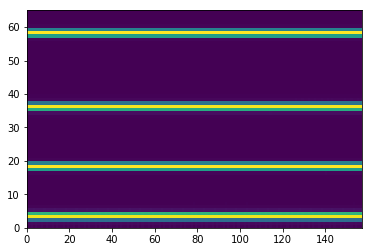

In [4]:
plt.pcolormesh(np.abs(spectrogram.transpose()))
print(spectrogram.shape)


In [5]:
inputSpectrograms = np.stack([np.real(spectrogram), np.imag(spectrogram)], axis=-1)
print(inputSpectrograms.shape)
generatedSpecs = aContextEncoderSystem.generate(inputSpectrograms, length=24, model_num=29418)[0]

(157, 65, 2)
INFO:tensorflow:Restoring parameters from utils/saved_models/test_RealImag_newNew_/model-test_RealImag_newNew_29418.ckpt
Model restored.


In [6]:
generatedSpecs = generatedSpecs[:, :, 0] + 1.0j * generatedSpecs[:, :, 1]


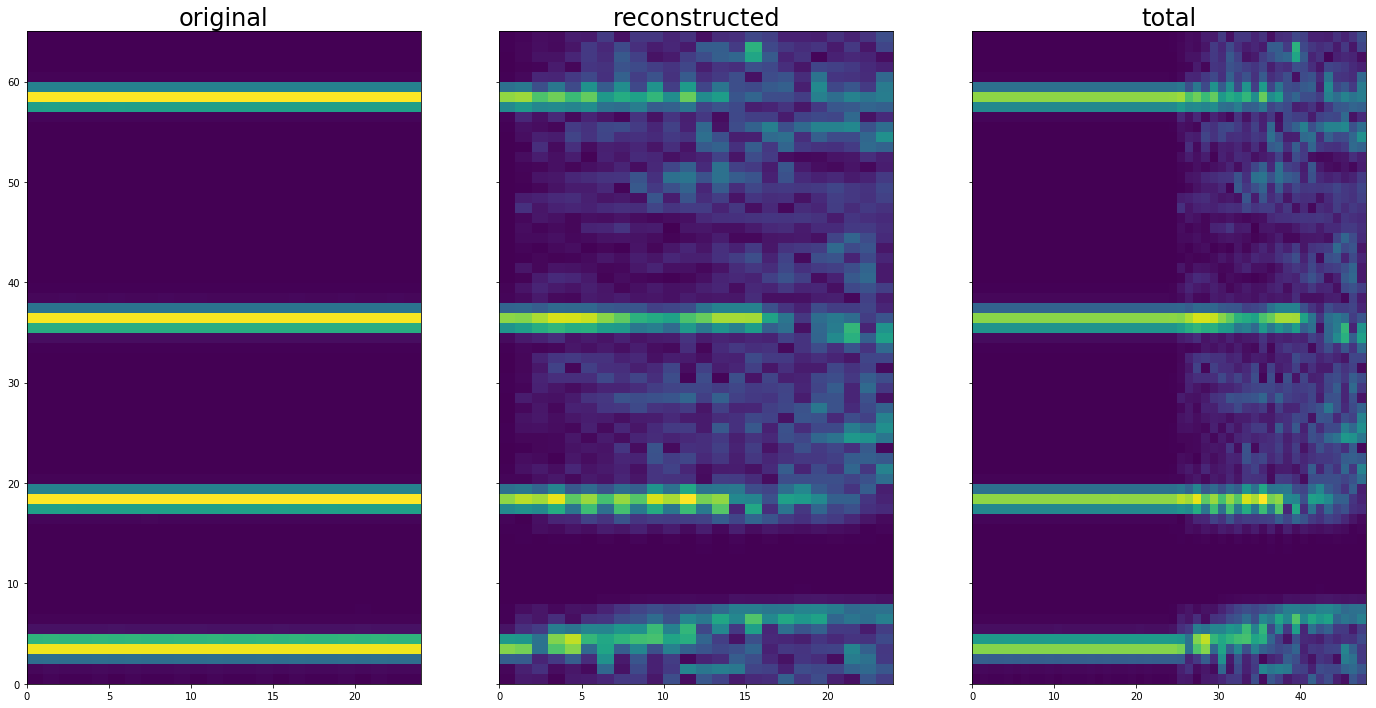

In [7]:
f, axarr = plt.subplots(1, 3, sharey='row', figsize=(24, 12))

axarr[0].pcolormesh(np.abs(generatedSpecs[133:157].transpose()))
axarr[0].set_title('original', size=24)
axarr[1].pcolormesh(np.abs(generatedSpecs[157:].transpose()))
axarr[1].set_title('reconstructed', size=24)
axarr[2].pcolormesh(np.abs(generatedSpecs[133:].transpose()))
axarr[2].set_title('total', size=24);

In [5]:
generatedSpecs.shape

(1, 160, 65)